# fig — rotate (develop code)

**Motivation**: host = ```mach```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from analysis.helper import first_digit_inds
from figures.analysis import *

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

In [3]:
fig_base_dir = pjoin(fig_base_dir, 'iclr_oct02', 'rotate')
os.makedirs(fig_base_dir, exist_ok=True)
print(os.listdir(fig_base_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

['MNIST_theta-90']

## VAE: amort and iterative

### iP-VAE

In [4]:
mnist_to_load = get_mnist_models(device)
print(sorted(mnist_to_load))

[
    '<conv|conv>_(16,8.0)',
    '<conv|conv>_(4,1.5)',
    '<jacob|conv>_(16,8.0)',
    '<jacob|conv>_(2,0.75)',
    '<jacob|conv>_(4,1.5)',
    '<jacob|mlp>_(16,8.0)',
    '<jacob|mlp>_(4,1.5)',
    '<jacob|mlp>_(64,24.0)',
    '<mlp|mlp>_(16,8.0)',
    '<mlp|mlp>_(4,1.5)',
    '<mlp|mlp>_(64,24.0)'
]

## Load rotated dataset

In [5]:
from analysis.corrupt import perform_corruption_analysis

load_dir = pjoin(tmp_dir, 'corrupted_data')
files = sorted(os.listdir(load_dir), key=alphanum_sort_key)

In [6]:
tgt_ds = 'MNIST'
pat = 'rotate-angle'
theta = 90

fig_dir = pjoin(fig_base_dir, f"{tgt_ds}_theta-{theta}")
os.makedirs(fig_dir, exist_ok=True)

In [7]:
f = next(
    f for f in files if (
        f.startswith(tgt_ds) and
        f"{pat}-{theta}" in f
    )
)
print(f)

analysis_name = f.split('.')[0]
print(analysis_name)

MNIST_rotate-angle-90.npy

MNIST_rotate-angle-90

In [8]:
corrupted_data = np.load(pjoin(load_dir, f), allow_pickle=True).item()
print({k: v for k, v in corrupted_data.items() if not k.startswith('x_')})

{'corruption_type': 'rotate', 'corruption_kws': {'angle': 90, 'hist_match': True, 'interpolation': 'bilinear'}}

In [9]:
kws_analysis = dict(
    tr=None,
    corrupted_data=corrupted_data,
    mse_wrt_orig=False,
    t_recon=-1,  # 1000
    verbose=False,
)

## Load trainer

In [10]:
trainers = {}
for name, kws_load in tqdm(mnist_to_load.items()):
    trainers[name] = load_model(**kws_load)[0]

100%|███████████████████████████████████████████| 11/11 [00:09<00:00,  1.14it/s]


## Perform analysis

  0%|                                                    | 0/11 [00:00<?, ?it/s]

______________________________________________________________________________________________________________

<jacob|conv>_(2,0.75)

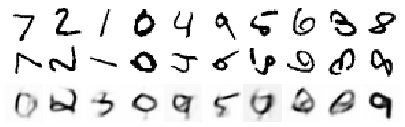

  9%|████                                        | 1/11 [00:17<02:50, 17.03s/it]

______________________________________________________________________________________________________________

<jacob|conv>_(4,1.5)

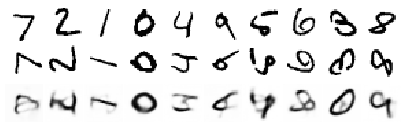

 18%|████████                                    | 2/11 [00:48<03:51, 25.76s/it]

______________________________________________________________________________________________________________

<conv|conv>_(4,1.5)

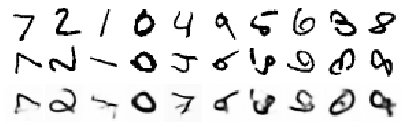

 27%|████████████                                | 3/11 [01:01<02:36, 19.53s/it]

______________________________________________________________________________________________________________

<jacob|conv>_(16,8.0)

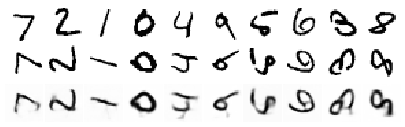

 36%|████████████████                            | 4/11 [03:06<07:09, 61.29s/it]

______________________________________________________________________________________________________________

<conv|conv>_(16,8.0)

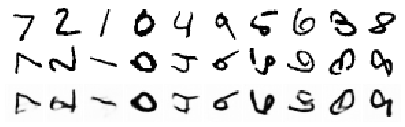

 45%|████████████████████                        | 5/11 [03:46<05:22, 53.67s/it]

______________________________________________________________________________________________________________

<jacob|mlp>_(4,1.5)

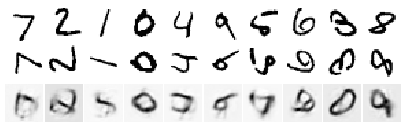

 55%|████████████████████████                    | 6/11 [03:50<03:04, 36.84s/it]

______________________________________________________________________________________________________________

<mlp|mlp>_(4,1.5)

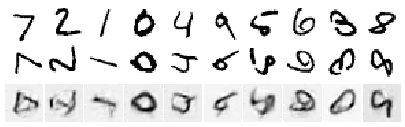

 64%|████████████████████████████                | 7/11 [03:53<01:42, 25.68s/it]

______________________________________________________________________________________________________________

<jacob|mlp>_(16,8.0)

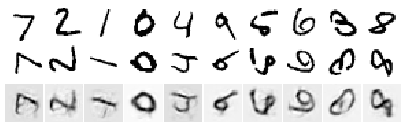

 73%|████████████████████████████████            | 8/11 [04:07<01:05, 21.87s/it]

______________________________________________________________________________________________________________

<mlp|mlp>_(16,8.0)

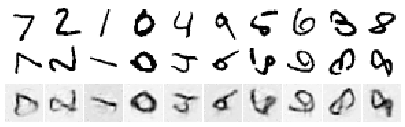

 82%|████████████████████████████████████        | 9/11 [04:14<00:34, 17.41s/it]

______________________________________________________________________________________________________________

<jacob|mlp>_(64,24.0)

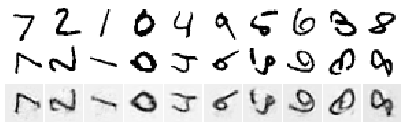

 91%|███████████████████████████████████████    | 10/11 [05:37<00:37, 37.62s/it]

______________________________________________________________________________________________________________

<mlp|mlp>_(64,24.0)

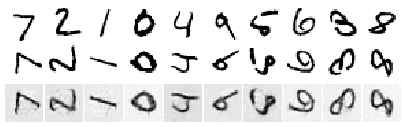

100%|███████████████████████████████████████████| 11/11 [06:15<00:00, 34.14s/it]


In [11]:
df = collections.defaultdict(list)

inds = None
for model_name, tr in tqdm(trainers.items()):
    if inds is None:
        inds = first_digit_inds(tr.dl_vld.dataset.tensors[1])

    kws_analysis['tr'] = tr
    results, accuracy = perform_corruption_analysis(
        **kws_analysis)

    # save results
    df['analysis_name'].append(analysis_name)
    df['model_name'].append(model_name)
    df['enc_type'].append(tr.model.cfg.enc_type)
    df['dec_type'].append(tr.model.cfg.dec_type)
    df['n_iters_train'].append(tr.model.cfg.seq_len)
    df['beta'].append(tr.cfg.kl_beta)
    df['mse'].append(results['mse'].mean())
    df['accuracy'].append(accuracy.mean())

    # save figs
    x = tonp(tr.dl_vld.dataset.tensors[0][inds])
    fig, ax = plot_row_or_col(x, row=False, display=False)
    fig.savefig(pjoin(fig_dir, f"{analysis_name}_{model_name}_inpt.png"), **kws_fig)
    
    x_corrupted = corrupted_data['x_corrupted_vld'][inds]
    fig, ax = plot_row_or_col(x_corrupted, row=False, display=False)
    fig.savefig(pjoin(fig_dir, f"{analysis_name}_{model_name}_corrpt.png"), **kws_fig)
    
    x_recon = results['recon'][inds]
    x_recon = x_recon.reshape(tr.model.cfg.shape)
    fig, ax = plot_row_or_col(x_recon, row=False, display=False)
    fig.savefig(pjoin(fig_dir, f"{analysis_name}_{model_name}_recon.png"), **kws_fig)

    # plot results
    print('_' * 110)
    print(model_name)
    _ = plot_weights(
        w=np.concatenate([x, x_corrupted, x_recon]),
        nrows=3, cmap='Greys', vmin=0.001, vmax=1, dpi=50,
    )
    print('\n\n')

df = pd.DataFrame(df)

In [13]:
df

,analysis_name,model_name,enc_type,dec_type,n_iters_train,beta,mse,accuracy
0,MNIST_rotate-angle-90,"<jacob|conv>_(2,0.75)",jacob,conv,2,0.75,32.841564,0.8727
1,MNIST_rotate-angle-90,"<jacob|conv>_(4,1.5)",jacob,conv,4,1.50,23.674599,0.8865
2,MNIST_rotate-angle-90,"<conv|conv>_(4,1.5)",conv,conv,4,1.50,23.644022,0.8899
3,MNIST_rotate-angle-90,"<jacob|conv>_(16,8.0)",jacob,conv,16,8.00,13.532087,0.8977
4,MNIST_rotate-angle-90,"<conv|conv>_(16,8.0)",conv,conv,16,8.00,16.561689,0.9071
5,MNIST_rotate-angle-90,"<jacob|mlp>_(4,1.5)",jacob,mlp,4,1.50,27.035778,0.9251
6,MNIST_rotate-angle-90,"<mlp|mlp>_(4,1.5)",mlp,mlp,4,1.50,24.846193,0.9289
7,MNIST_rotate-angle-90,"<jacob|mlp>_(16,8.0)",jacob,mlp,16,8.00,15.902637,0.9487
8,MNIST_rotate-angle-90,"<mlp|mlp>_(16,8.0)",mlp,mlp,16,8.00,17.151144,0.9405
9,MNIST_rotate-angle-90,"<jacob|mlp>_(64,24.0)",jacob,mlp,64,24.00,9.149092,0.9479


## Now best models ($T=100$)

conv: ```<jacob|conv>_(16,8.0)```  
mlp: ```<jacob|mlp>_(64,24.0)```

In [11]:
kws_analysis = dict(
    tr=None,
    corrupted_data=corrupted_data,
    mse_wrt_orig=False,
    t_recon=100,
    verbose=True,
)

In [12]:
best_models = [
    '<jacob|mlp>_(64,24.0)',
    '<jacob|conv>_(16,8.0)',
]

100%|█████████████████████████████████████████| 300/300 [12:10<00:00,  2.44s/it]


______________________________________________________________________________________________________________

<jacob|conv>_(16,8.0)

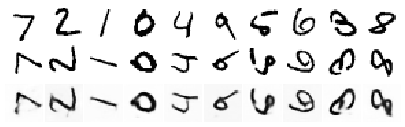

100%|█████████████████████████████████████████| 300/300 [01:57<00:00,  2.55it/s]


______________________________________________________________________________________________________________

<jacob|mlp>_(64,24.0)

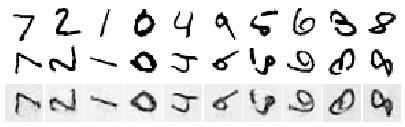

In [13]:
df = collections.defaultdict(list)

inds = None
for model_name, tr in trainers.items():
    if model_name not in best_models:
        continue
    if inds is None:
        inds = first_digit_inds(tr.dl_vld.dataset.tensors[1])
    kws_analysis['tr'] = tr
    results, accuracy = perform_corruption_analysis(
        **kws_analysis)

    # save results
    df['analysis_name'].append(analysis_name)
    df['model_name'].append(model_name)
    df['enc_type'].append(tr.model.cfg.enc_type)
    df['dec_type'].append(tr.model.cfg.dec_type)
    df['n_iters_train'].append(tr.model.cfg.seq_len)
    df['beta'].append(tr.cfg.kl_beta)
    df['mse'].append(results['mse'].mean())
    df['accuracy'].append(accuracy.mean())

    # prep material to plot
    x = tonp(tr.dl_vld.dataset.tensors[0][inds])
    x_corrupted = corrupted_data['x_corrupted_vld'][inds]
    x_recon = results['recon'][inds]
    x_recon = x_recon.reshape(tr.model.cfg.shape)

    # save figs
    # input
    # fig, ax = plot_row_or_col(x, row=False, display=False)
    # fig.savefig(pjoin(fig_dir, f"{analysis_name}_{model_name}_inpt.png"), **kws_fig)
    # corrupted version
    # fig, ax = plot_row_or_col(x_corrupted, row=False, display=False)
    # fig.savefig(pjoin(fig_dir, f"{analysis_name}_{model_name}_corrpt.png"), **kws_fig)
    # reconstruction
    # fig, ax = plot_row_or_col(x_recon, row=False, display=False)
    # fig.savefig(pjoin(fig_dir, f"{analysis_name}_{model_name}_recon.png"), **kws_fig)

    # plot results
    print('_' * 110)
    print(model_name)
    _ = plot_weights(
        w=np.concatenate([x, x_corrupted, x_recon]),
        nrows=3, cmap='Greys', vmin=0.001, vmax=1, dpi=50,
    )
    print('\n\n')

df = pd.DataFrame(df)

In [14]:
df

,analysis_name,model_name,enc_type,dec_type,n_iters_train,beta,mse,accuracy
0,MNIST_rotate-angle-90,"<jacob|conv>_(16,8.0)",jacob,conv,16,8.0,7.879054,0.8867
1,MNIST_rotate-angle-90,"<jacob|mlp>_(64,24.0)",jacob,mlp,64,24.0,8.531110,0.9455


In [18]:
w = tr.model.layer.get_weight()
kurt = sp_stats.kurtosis(tonp(w), axis=1)

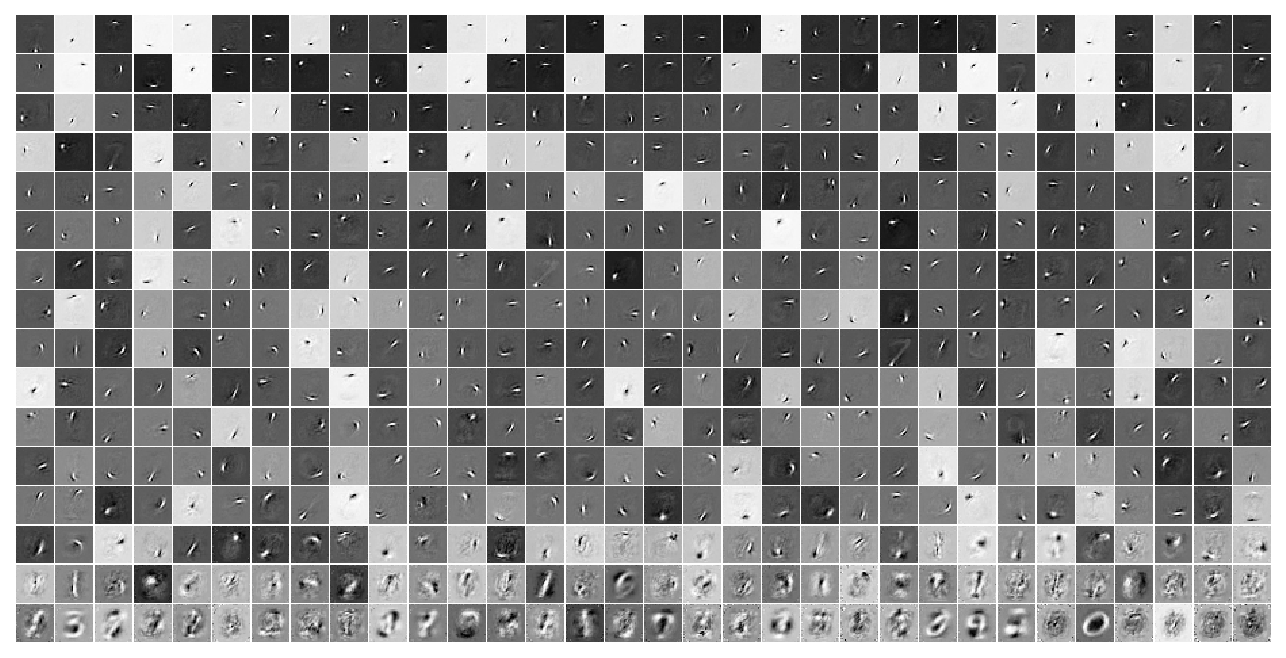

In [28]:
tr.model.show(order=np.argsort(kurt)[::-1]);